This is the file to build our XLNet + ABC algorithm, and train our data.  

## Recap

As recap:  

- **Dataset Info**: We have four cleaned datasets: "data_afterDrop_q1.npy", "data_afterDrop_q2.npy", "data_afterDrop_q3.npy", "data_afterDrop_q4.npy". Each dataset has shape (225, 84). We want to combine all four datasets into a big one with shape (900, 84), then convert it into a model trainable format(as *torch.tensor*). We got a finalized dataset ready for training in shape <u>x: torch.Size([900, 1187]); y: torch.Size([900])</u>

- **Model**:   
        
    <u>1. #1</u>: XLNet(Transformer Based): a large bidirectional transformer, improves upon BERT by using the Transformer XL as its base architecture.  

    <img src="XLNet.png" alt="XLNet" style="width:500px; height: auto;">
    
    **Model Input**: lyrics; BUT we will use our features transformed by librosa package.  
    **Model Output**: raw hidden states; Then the output will be passed on to SequenceSummary block, which computes a single vector summary of a sequence of hidden states, followed by one more hidden Fully-Connected (FC) layer which encodes the information into a vector of length 8. 
    
    <blockquote>
    <p>Transformer-XL (meaning extra long) is a Transformer architecture that introduces the notion of recurrence to the deep self-attention network. Instead of computing the hidden states from scratch for each new segment, Transformer-XL reuses the hidden states obtained in previous segments. The reused hidden states serve as memory for the current segment, which builds up a recurrent connection between the segments. As a result, modeling very long-term dependency becomes possible because information can be propagated through the recurrent connections. As an additional contribution, the Transformer-XL uses a new relative positional encoding formulation that generalizes to attention lengths longer than the one observed during training.</p>
    <img src="TransformerXL.png" alt="TransformerXL" style="width: 500px; height: auto;">
    <footer>— Introduced in paper by Dai et al., <cite>https://arxiv.org/abs/1901.02860v3</cite></footer>
    </blockquote>

    **!! Why this is not achievable:** This is not achievable for us now because it needs more time and efforts to change the numerical features into words that XLNet can recognize and run. Then, we might decide to move to other models to try.

    <u>2. #2</u>: XLNet + Artificial Bee Colony Algorithm.

    **!! Why this is not achievable:** Same reason as the baseline model, we cannot use XLNet within the time range.

    <u>3. #3</u>: RNNs(Recurrent Neural Networks): a neural network that is specialized for processing a sequence of data x(t)= x(1), . . . , x(τ) with the time step index t ranging from 1 to τ. RNNs have a “memory” which captures information about what has been calculated so far. A Recurrent Neural Network can be thought of as multiple copies of the same network, each passing a message to a successor.

    <img src="RNNsUnroll.png" alt="XLNet" style="width:500px; height: auto;">

    **Model Input:** Numerical features we got after using Librosa for 900 audios.  
    **Model Output:** {0, 1, 2, 3} represents Q1, Q2, Q3, Q4 for the Russell's Music Quadrant.

- Issues:

    1. The model seems not training well using the datasets we have cleaned. For RNNs, the input data needs to be able to tell something from its sequential structure, but right now, not all the features in our data express the same thing.

    Solution: check the features after transforming using Librosa, keep all the features with shape (__, 1295) where 1295 is the number of time frames, and stack them together.

    They are: "chroma_stft" (12, 1295), "chroma_cqt" (12, 1295), "chroma_vqt" (12, 1295), "melspectrogram" (128, 1295), "mfcc" (20, 1295), "rms" (1, 1295), "spectral_centroid" (1, 1295), "spectral_bandwidth" (1, 1295), "spectral_contrast" (7, 1295), "spectral_flatness" (1, 1295), "spectral_rolloff" (1, 1295), "tonnetz" (6, 1295), "zero_crossing_rate" (1, 1295), "tempo" (1,) **we'll want to pad this into a (1, 1295)**

In [1]:
# packages used
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm, trange
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

## Clean Data

1. Transform audio into features using Librosa
2. Keep only the features having shape(__, 1295) which 1295 represents the number of time frames

    Drop 6 features: "xs", "srs", "chroma_cens_demos", "tempogram", "fourier_tempogram", "tempogram_ratio"
    
    Keep 14 features and 1 labels columns
3. Padding "tempo" from shape(1, ) to (1, 1295)
4. At the end, I should get a well-prepared dataset with shape(900, 15) with each feature as shape(__, 1295)
5. Then stack all 14 features into one (__, 1295) vector for each of the 900 data. Return shape(900, 204, 1295) for X, (900,) for y.

In [13]:
# loading data after using Librosa transforms the features
data_q1 = np.load('dataset/all_features_q1.npy', allow_pickle=True)
data_q2 = np.load('dataset/all_features_q2.npy', allow_pickle=True)
data_q3 = np.load('dataset/all_features_q3.npy', allow_pickle=True)
data_q4 = np.load('dataset/all_features_q4.npy', allow_pickle=True)
df_cols = data_q1.item().keys()

In [14]:
df_cols

dict_keys(['xs', 'srs', 'chroma_stft_demos', 'chroma_cqt_demos', 'chroma_vqt_demos', 'chroma_cens_demos', 'melspectrogram_demos', 'mfcc_demos', 'rms_demos', 'spectral_centroid_demos', 'spectral_bandwidth_demos', 'spectral_contrast_demos', 'spectral_flatness_demos', 'spectral_rolloff_demos', 'tonnetz_demos', 'zero_crossing_rate_demos', 'tempo', 'tempogram', 'fourier_tempogram', 'tempogram_ratio', 'labels'])

In [15]:
# change from np to dataframe for cleaning datas
df_q1 = pd.DataFrame(data_q1.item(), columns=df_cols)
df_q2 = pd.DataFrame(data_q2.item(), columns=df_cols)
df_q3 = pd.DataFrame(data_q3.item(), columns=df_cols)
df_q4 = pd.DataFrame(data_q4.item(), columns=df_cols)

In [16]:
df_q1.head(1)

,xs,srs,chroma_stft_demos,chroma_cqt_demos,chroma_vqt_demos,chroma_cens_demos,melspectrogram_demos,mfcc_demos,rms_demos,spectral_centroid_demos,...,spectral_contrast_demos,spectral_flatness_demos,spectral_rolloff_demos,tonnetz_demos,zero_crossing_rate_demos,tempo,tempogram,fourier_tempogram,tempogram_ratio,labels
0,"[2.5885166e-15, -3.28127e-16, 1.3183922e-14, 2...",22050,"[[0.64465576, 0.5051329, 0.6534084, 0.679588, ...","[[0.5660721, 0.5691674, 0.5468383, 0.45331684,...","[[0.848989, 0.8981467, 0.73216736, 0.62612474,...","[[0.15784575, 0.15223381, 0.14725037, 0.142912...","[[1.3533841e-08, 3.5398793e-06, 0.00014950961,...","[[-556.7651, -511.8035, -422.1127, -383.47598,...","[[0.0005485677, 0.0020291524, 0.0029873797, 0....","[[2600.362152387303, 2068.7657054944157, 1942....",...,"[[3.8653191299605147, 17.12577068070992, 14.64...","[[0.041992728, 0.00600211, 0.004467108, 0.0047...","[[5264.8681640625, 4166.6748046875, 3929.80957...","[[-0.07177943340504166, -0.06567968650338962, ...","[[0.0654296875, 0.087890625, 0.1142578125, 0.1...",[129.19921875],"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[(166.63167+0j), (168.14557+0j), (169.65591+0...","[[0.5631348673732673, 0.5627342679353834, 0.56...",1


In [17]:
# Need to drop "xs", "srs", "chroma_cens_demos", "tempogram", "fourier_tempogram", "tempogram_ratio"
drop_cols=["xs", "srs", "chroma_cens_demos", "tempogram", "fourier_tempogram", "tempogram_ratio"]
df_q1 = df_q1.drop(columns=drop_cols)  # shape (225, 15)
df_q2 = df_q2.drop(columns=drop_cols)  # shape (225, 15)
df_q3 = df_q3.drop(columns=drop_cols)  # shape (225, 15)
df_q4 = df_q4.drop(columns=drop_cols)  # shape (225, 15)

In [18]:
# stack all four dataframes into one
df = pd.concat([df_q1, df_q2, df_q3, df_q4], ignore_index=True, axis=0)  # axis=0, stack vertically
df.shape  # (900, 15)

(900, 15)

In [19]:
df["tempo"] = df["tempo"].apply(lambda x: np.repeat(x, 1295).reshape(1, 1295))
df["tempo"]

0      [[129.19921875, 129.19921875, 129.19921875, 12...
1      [[161.4990234375, 161.4990234375, 161.49902343...
2      [[99.38401442307692, 99.38401442307692, 99.384...
3      [[123.046875, 123.046875, 123.046875, 123.0468...
4      [[103.359375, 103.359375, 103.359375, 103.3593...
                             ...                        
895    [[112.34714673913044, 112.34714673913044, 112....
896    [[123.046875, 123.046875, 123.046875, 123.0468...
897    [[129.19921875, 129.19921875, 129.19921875, 12...
898    [[99.38401442307692, 99.38401442307692, 99.384...
899    [[143.5546875, 143.5546875, 143.5546875, 143.5...
Name: tempo, Length: 900, dtype: object

In [20]:
df.columns = [col.replace('_demos', '') for col in df.columns]
full_cols = df.columns
full_cols

Index(['chroma_stft', 'chroma_cqt', 'chroma_vqt', 'melspectrogram', 'mfcc',
       'rms', 'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast',
       'spectral_flatness', 'spectral_rolloff', 'tonnetz',
       'zero_crossing_rate', 'tempo', 'labels'],
      dtype='object')

In [21]:
# Some data having (__, >1295): deleting
# Some data having (__, <1295): padding 0's
def adjust_array(array):
    target_cols = 1295
    array = np.array(array)
    
    current_rows, current_cols = array.shape
    
    if current_cols < target_cols:
        # Pad the array
        pad_width = [(0, 0), (0, target_cols - current_cols)]  # No padding for rows, appropriate padding for columns
        array = np.pad(array, pad_width=pad_width, mode='constant', constant_values=0)
    elif current_cols > target_cols:
        # Truncate the array
        array = array[:, :target_cols]
    
    return array

In [22]:
for column in full_cols[:-1]:
    df[column] = df[column].apply(adjust_array)

In [23]:
# Save data into .npy
df_array = df.to_numpy()
np.save("dataset/dataForNN.npy", df_array)

In [24]:
# Load Data
# save to .npy after drop
data_path = "dataset/dataForNN.npy"

# np.load
data = np.load(data_path, allow_pickle=True)

# we have below columns
cols = ['chroma_stft', 'chroma_cqt', 'chroma_vqt',
       'melspectrogram', 'mfcc', 'rms',
       'spectral_centroid', 'spectral_bandwidth',
       'spectral_contrast', 'spectral_flatness',
       'spectral_rolloff', 'tonnetz', 'zero_crossing_rate',
       'tempo', 'labels']

In [25]:
# Initialize a list to hold vertically stacked arrays
stacked_features = []

# Iterate through each row, but exclude the last column (labels)
for row in data[:, :-1]:
    # Stack arrays vertically (vstack) and then reshape to ensure it's a 2D array
    stacked_row = np.vstack(row).reshape(-1, 1295)
    #print(stacked_row.shape)
    stacked_features.append(stacked_row)

# Convert the list of arrays into a single 3D NumPy array
stacked_data = np.array(stacked_features)

In [26]:
stacked_data.shape

(900, 204, 1295)

In [27]:
# Finished stacking data
np.save("dataset/complete_data_X.npy", stacked_data)
np.save("dataset/complete_data_y.npy", data[:, -1]-1) # shift 1, 2, 3, 4 to 0, 1, 2, 3

Here is the end of dealing with data.

## Prepare Data for Training

1. Convert numpy array to torch.Tensor
2. Split train-test set
3. Normalize train set data as a whole and save the train data mean and variance
4. Use train data mean and variance to normalize test data.

In [2]:
# load data
X_arr = np.load("dataset/complete_data_X.npy", allow_pickle=True)
y_arr = np.load("dataset/complete_data_y.npy", allow_pickle=True)
print(f"X.shape: {X_arr.shape}")
print(f"y.shape: {y_arr.shape}")

X.shape: (900, 204, 1295)
y.shape: (900,)


In [3]:
# convert y_arr
if y_arr.dtype == np.object_:
    y_arr = y_arr.astype(np.int64)

In [4]:
# 1. change array to tensor
X = torch.from_numpy(X_arr).to(torch.float32)
y = torch.from_numpy(y_arr)
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: torch.Size([900, 204, 1295])
y.shape: torch.Size([900])


In [5]:
# 2. Train-Test Split
# train, eval, test set have proportion: 8:1:1
# stratified data, so that all three sets contains
#   the same proportion of data for the four classes.
# Assume X and y are your dataset and labels respectively
X_train_eval, X_test, y_train_eval, y_test = train_test_split(X, y, test_size=0.1, random_state=602, stratify=y)

# Train-Eval Split
X_train, X_eval, y_train, y_eval = train_test_split(X_train_eval, y_train_eval, test_size=1/9, random_state=602, stratify=y_train_eval)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_eval.shape: {X_eval.shape}")
print(f"y_eval.shape: {y_eval.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: torch.Size([720, 204, 1295])
y_train.shape: torch.Size([720])
X_eval.shape: torch.Size([90, 204, 1295])
y_eval.shape: torch.Size([90])
X_test.shape: torch.Size([90, 204, 1295])
y_test.shape: torch.Size([90])


In [6]:
# 3. Normalize train set data
# store mean and varianve of train set data
train_mean_X = X_train.mean(dim=[0, 1, 2])
train_std_X = X_train.std(dim=[0, 1, 2])

X_train_norm = (X_train - train_mean_X) / train_std_X

# 4. Use train set mean and std to normalize test set
X_eval_norm = (X_eval - train_mean_X) / train_std_X
X_test_norm = (X_test - train_mean_X) / train_std_X

In [7]:
# Define a Dataset class
# More convenient to deal with data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        y = self.y[idx]
        X = self.X[idx]
        return (X, y)

In [8]:
X_train_norm.transpose(1, 2).shape

torch.Size([720, 1295, 204])

In [9]:
# train set data: X_train_norm, y_train
# test  set data: X_test_norm,  y_test

# Since the model needs a (720, 1295, 204) shape, 
# need to change current (720, 204, 1295) to (720, 1295, 204)
X_train_norm = X_train_norm.transpose(1, 2)
X_eval_norm = X_eval_norm.transpose(1, 2)
X_test_norm = X_test_norm.transpose(1, 2)

train_data = MyDataset(X_train_norm, y_train)
eval_data  = MyDataset(X_eval_norm, y_eval)
test_data  = MyDataset(X_test_norm, y_test)

## Train Models
1. RNNs: able to capture previous time steps' contents

    <img src="RNNsUnroll.png" alt="XLNet" style="width:400px; height: auto;">

2. Bi-Direction RNNs: able to make connects to previous time steps and later time steps.

    <img src="bidir-RNN.png" alt="bidir-RNN" style="width:200px; height: auto;">

3. LSTM: able to solve the problems of gradient exploration and gradient vanishing

    <img src="LSTM.png" alt="LSTM" style="width:300px; height: auto;">

### RNNs

In [66]:
### Xinyu(Xiyah) Chang ###

# Define RNN Model
# Need a input with shape (720, 1295, 204)
class MusicEmotionRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MusicEmotionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True gives the input and output tensors in the format:
        # (batch, seq, feature) instead of (seq, batch, feature)
        # batch: 720
        # seq: which is timestep, here should be 1295
        # feature: 204
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # Fully Connected Layer output the prediction
        self.fc = nn.Sequential(
            # BatchNorm
            # Normalizes the activations of a layer for each batch, 
            # maintaining the mean output close to 0 and the output 
            # standard deviation close to 1. This can lead to faster convergence 
            # and overall improved training stability.
            # https://stackoverflow.com/questions/42359860/add-batch-normalization-immediately-before-non-linearity-or-after-in-keras
            nn.Dropout(p=0.2), # add droppout prevent overfit
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            #nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        # Initialize hidden and cell states
        # x.size(0) is batch size
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the RNN
        _, ht = self.rnn(x, h0)
        # print(f"out: {out}")
        # print(f"ht: {ht}")
        # print(ht.shape)
        # Pass the hidden state of the last time step to the fc layer
        out = self.fc(ht[0])
        return out
### Xinyu(Xiyah) Chang ###

In [77]:
# Model Params
input_size = 204     # seq in (batch, seq, feature)
hidden_size = 128    # Can adjust based on model complexity and dataset, used: 128
num_layers = 1       # Number of RNN layers, 1 or 2, 1 is better by training
num_classes = 4      # Four quadrants
learning_rate = 1e-4 # Can adjust this learing rate， 1e-4, 3e-4, 1e-3, 3e-3
num_epochs = 2000      # Number of epochs
batch_size = 128     # size of batch

rnn_model = MusicEmotionRNN(input_size, hidden_size, num_layers, num_classes)

In [78]:
# Use DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(dataset=eval_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Assuming use of CrossEntropyLoss and an optimizer Adam
criterion = nn.CrossEntropyLoss()

In [79]:
### Xinyu(Xiyah) Chang ###

# Define the device 
# "cuda", "mps", "cpu"
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda')

# Move model to the chosen device
rnn_model = rnn_model.to(device)
optimizer = optim.AdamW(rnn_model.parameters(), lr=learning_rate)

total_batches = math.ceil( X_train_norm.shape[0] / batch_size)
#total_batches = 7
rnn_model.train()  

# record train acc and loss
rnn_train_acc = []
rnn_train_loss = []

# record eval acc
rnn_eval_acc = []

for epoch in trange(num_epochs):
    running_loss = 0.0
    prog = enumerate(train_loader) #tqdm(enumerate(train_loader), total=total_batches, desc=f'Epoch {epoch+1}/{num_epochs}')

    # initialize accuracy count for each new epoch
    correct = 0
    total = 0

    for i, (inputs, labels) in prog:
        # Move data to the chosen device
        # print(inputs)
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.shape)

        # Forward pass
        outputs = rnn_model(inputs)
        # print(outputs.shape)
        # print(outputs, labels)
        # break
        loss = criterion(outputs, labels)

        # Zero the parameter gradients
        optimizer.zero_grad(set_to_none=False)

        # Backward pass and optimize
        loss.backward()

        # clip gradient to prevent explosion
        torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), 20.0)
        optimizer.step()

        running_loss += loss.item()
        __, predicted = torch.max(outputs.data, dim=1)
        # print(f"predicted: {predicted}")
        # print(f"labels: {labels}")
        # print((predicted==labels).sum())   # tensor(41, device='mps:0')
        
        # record train acc for each batch loop
        correct += (predicted==labels).sum().item()
        total += labels.size(0)
        #print(ct_acc)

    # calculate average loss and acc over training batches
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    rnn_train_acc.append(epoch_acc)
    rnn_train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc_train: {epoch_acc:.4f}')

    # evaluate using eval for each epoch
    rnn_model.eval() 

    with torch.inference_mode():
        eval_correct=0
        eval_total=0
        for i, (inputs, labels) in enumerate(eval_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = rnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

        eval_accuracy = eval_correct / eval_total
        rnn_eval_acc.append(eval_accuracy)
        print(f'Validation Accuracy: {eval_accuracy:.4f}%')
    
    # set the model back to train mode
    rnn_model.train()
    
### Xinyu(Xiyah) Chang ###

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1/2000, Loss: 1.4216, Acc_train: 0.2611
Validation Accuracy: 0.3111%
Epoch 2/2000, Loss: 1.3931, Acc_train: 0.2806
Validation Accuracy: 0.3111%
Epoch 3/2000, Loss: 1.3921, Acc_train: 0.2833
Validation Accuracy: 0.2889%
Epoch 4/2000, Loss: 1.3818, Acc_train: 0.2806
Validation Accuracy: 0.2889%
Epoch 5/2000, Loss: 1.3786, Acc_train: 0.2875
Validation Accuracy: 0.2889%
Epoch 6/2000, Loss: 1.3618, Acc_train: 0.3042
Validation Accuracy: 0.2889%
Epoch 7/2000, Loss: 1.3601, Acc_train: 0.3264
Validation Accuracy: 0.2889%
Epoch 8/2000, Loss: 1.3428, Acc_train: 0.2931
Validation Accuracy: 0.2667%
Epoch 9/2000, Loss: 1.3407, Acc_train: 0.3486
Validation Accuracy: 0.2556%
Epoch 10/2000, Loss: 1.3401, Acc_train: 0.3125
Validation Accuracy: 0.2556%
Epoch 11/2000, Loss: 1.3220, Acc_train: 0.3458
Validation Accuracy: 0.2889%
Epoch 12/2000, Loss: 1.3252, Acc_train: 0.3444
Validation Accuracy: 0.3111%
Epoch 13/2000, Loss: 1.3343, Acc_train: 0.3250
Validation Accuracy: 0.3000%
Epoch 14/2000, Loss: 

In [80]:
# check if the variables are stored correctly
print(len(rnn_train_acc))
print(len(rnn_train_loss))
print(len(rnn_eval_acc))

2000
2000
2000


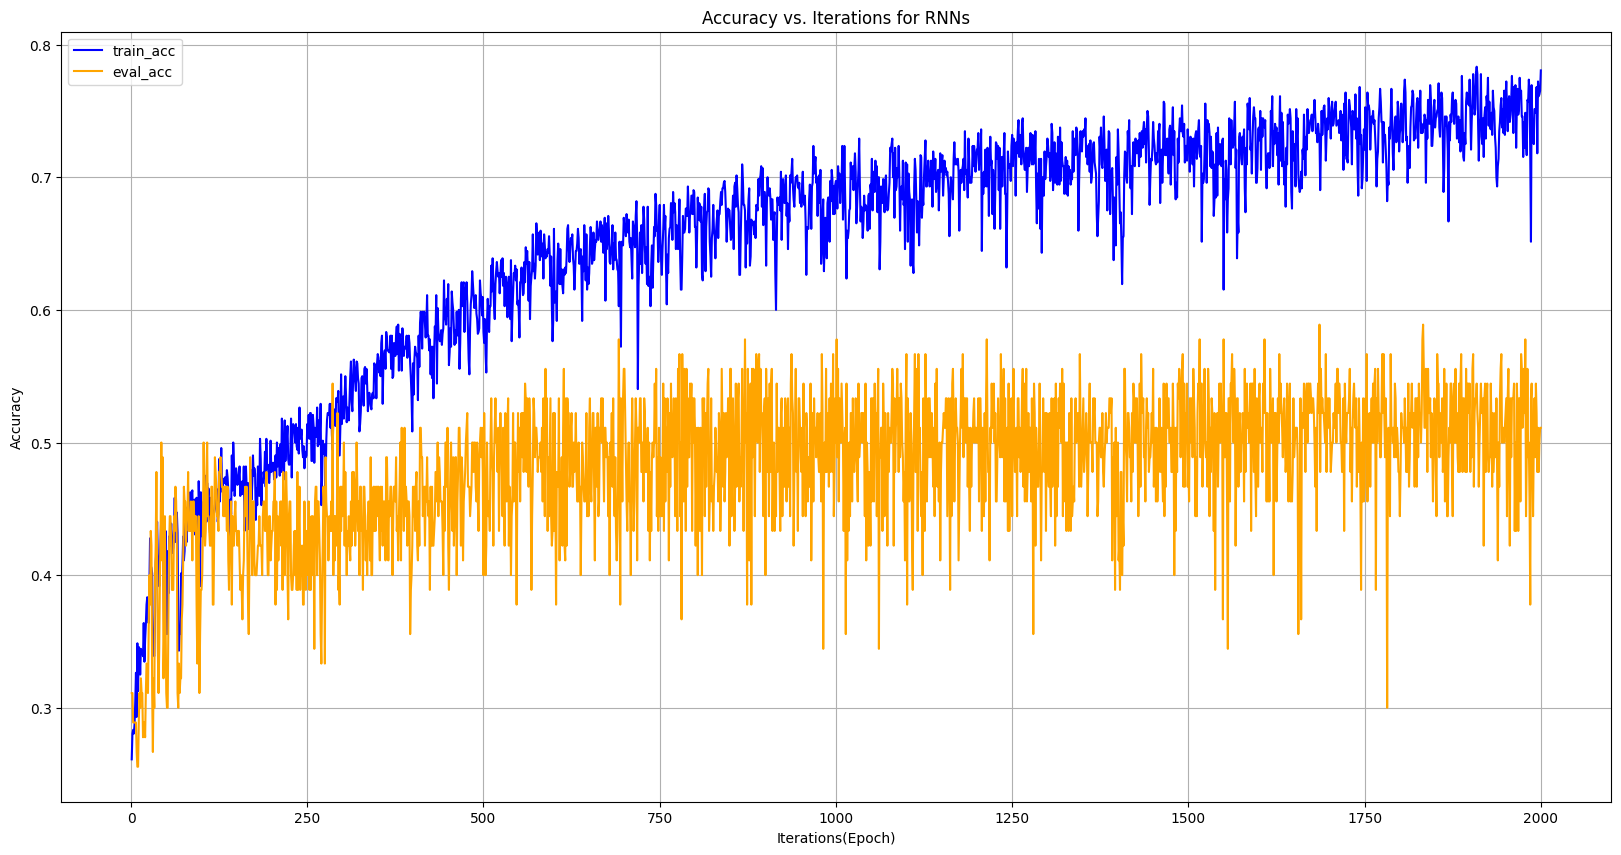

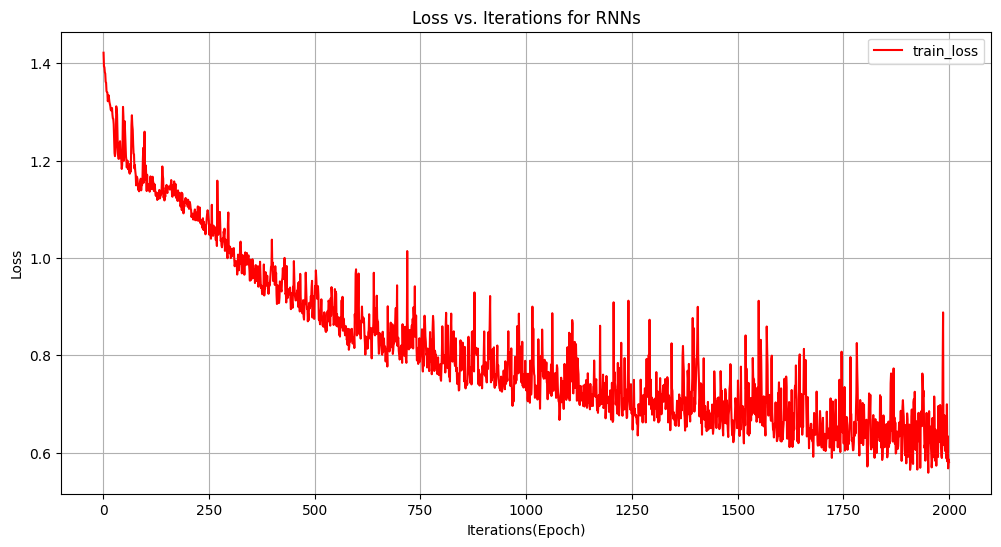

In [81]:
# plot train acc vs. iterations(epoch)
x_axis = list(range(1, num_epochs+1))
plt.figure(figsize=(20, 10))
# plot train acc
plt.plot(x_axis, rnn_train_acc, color='blue')
# plot eval acc
plt.plot(x_axis, rnn_eval_acc, color='orange')
#plt.xscale('log')
plt.xlabel('Iterations(Epoch)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iterations for RNNs')
plt.grid(True)
plt.legend(['train_acc', 'eval_acc'])
plt.show()

# plot train loss vs. iterations(epoch)
plt.figure(figsize=(12, 6))
plt.plot(x_axis, rnn_train_loss, color='red')
#plt.xscale('log')
plt.xlabel('Iterations(Epoch)')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations for RNNs')
plt.grid(True)
plt.legend(['train_loss'])
plt.show()

**TODO**:

From the plots above we could observe that the train and eval accuracy is still continuing climbing up through the 2000 trains, will continue to train for larger iterations if we got more time.

In [82]:
# Evaluate the rnn model
rnn_model.eval()  
correct = 0
total = 0

with torch.inference_mode():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = rnn_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        #print(outputs, predicted, labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy on the test set: 53.333333333333336%


Done with basic RNNs model.

### Bidirectional RNNs

In [83]:
### Xinyu(Xiyah) Chang ###

# Define Bidirectional-RNN Model
# Need a input with shape (720, 1295, 204)
class MusicEmotionBiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MusicEmotionBiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True gives the input and output tensors in the format:
        # (batch, seq, feature) instead of (seq, batch, feature)
        # batch: 720
        # seq: which is timestep, here should be 1295
        # feature: 204
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True) # add bidirectional
        # Fully Connected Layer output the prediction
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2), # add droppout prevent overfit
            nn.Linear(hidden_size*2, hidden_size), # from (hiddensize, hiddensize) to (hiddensize*2, hiddensize)
                                                # make it consistent with forward output.
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            #nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        # Initialize hidden and cell states
        # x.size(0) is batch size
        # Bidirectional Rnn returns 
        # h0: tensor of shape (2*Number of Layers, Batchsize, hidden_size)
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the RNN
        _, ht = self.rnn(x, h0)
        # print(f"out: {out}")
        # print(f"ht: {ht}")
        #print(f"before stack ht shape: {ht.shape}")
        
        # Pass the hidden state of the last time step to the fc layer
        # ht should be (2*num_layers, batchsize, hidden_size)
        # here: (2, 128, 128)
        # will want to make this stack together to be a (128, 256)
        stack_ht = torch.cat((ht[0], ht[1]), dim=1)
        #print(f"after stack ht shape: {stack_ht.shape}")
        out = self.fc(stack_ht)
        return out
### Xinyu(Xiyah) Chang ###

In [84]:
# Model Params
input_size = 204     # seq in (batch, seq, feature)
hidden_size = 128    # Can adjust based on model complexity and dataset, used: 128
num_layers = 1       # Number of RNN layers, 1 or 2, 1 is better by training
num_classes = 4      # Four quadrants
learning_rate = 1e-4 # Can adjust this learing rate， 1e-4, 3e-4, 1e-3, 3e-3
num_epochs = 2000      # Number of epochs
batch_size = 128     # size of batch

bi_rnn_model = MusicEmotionBiRNN(input_size, hidden_size, num_layers, num_classes)

# Use DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(dataset=eval_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Assuming use of CrossEntropyLoss and an optimizer Adam
criterion = nn.CrossEntropyLoss()

In [85]:
### Xinyu(Xiyah) Chang ###

# Define the device 
# "cuda", "mps", "cpu"
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda')

# Move model to the chosen device
bi_rnn_model = bi_rnn_model.to(device)
bi_rnn_optimizer = optim.AdamW(bi_rnn_model.parameters(), lr=learning_rate)

total_batches = math.ceil( X_train_norm.shape[0] / batch_size)
#total_batches = 7
bi_rnn_model.train()  

# record train acc and loss
bi_rnn_train_acc = []
bi_rnn_train_loss = []

# record eval acc
bi_rnn_eval_acc = []

for epoch in trange(num_epochs):
    running_loss = 0.0
    prog = enumerate(train_loader) #tqdm(enumerate(train_loader), total=total_batches, desc=f'Epoch {epoch+1}/{num_epochs}')

    # initialize accuracy count for each new epoch
    correct = 0
    total = 0

    for i, (inputs, labels) in prog:
        # Move data to the chosen device
        # print(inputs)
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.shape)

        # Forward pass
        outputs = bi_rnn_model(inputs)
        # print(outputs.shape)
        # print(outputs, labels)
        # break
        loss = criterion(outputs, labels)

        # Zero the parameter gradients
        bi_rnn_optimizer.zero_grad(set_to_none=False)

        # Backward pass and optimize
        loss.backward()

        # clip gradient to prevent explosion
        torch.nn.utils.clip_grad_norm_(bi_rnn_model.parameters(), 20.0)
        bi_rnn_optimizer.step()

        running_loss += loss.item()
        __, predicted = torch.max(outputs.data, dim=1)
        # print(f"predicted: {predicted}")
        # print(f"labels: {labels}")
        # print((predicted==labels).sum())   # tensor(41, device='mps:0')
        correct += (predicted==labels).sum().item()                         # Easily getting Error!
                                                    # before modifying, this part I forgot to add up "total" for all batches loops
        total += labels.size(0)
        #print(ct_acc)

    # calculate average loss and acc over training batches
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    bi_rnn_train_acc.append(epoch_acc)
    bi_rnn_train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc_train: {epoch_acc:.4f}')

    # evaluate using eval for each epoch
    bi_rnn_model.eval() 

    with torch.inference_mode():
        eval_correct=0
        eval_total=0
        for i, (inputs, labels) in enumerate(eval_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = bi_rnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

        eval_accuracy = eval_correct / eval_total
        bi_rnn_eval_acc.append(eval_accuracy)
        print(f'Validation Accuracy: {eval_accuracy:.4f}%')
    
    # set the model back to train mode
    bi_rnn_model.train()

### Xinyu(Xiyah) Chang ###

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000, Loss: 1.4270, Acc_train: 0.2625
Validation Accuracy: 0.2667%
Epoch 2/1000, Loss: 1.3936, Acc_train: 0.3194
Validation Accuracy: 0.2667%
Epoch 3/1000, Loss: 1.3751, Acc_train: 0.3097
Validation Accuracy: 0.2667%
Epoch 4/1000, Loss: 1.3537, Acc_train: 0.3389
Validation Accuracy: 0.2667%
Epoch 5/1000, Loss: 1.3397, Acc_train: 0.3569
Validation Accuracy: 0.3333%
Epoch 6/1000, Loss: 1.3102, Acc_train: 0.3750
Validation Accuracy: 0.3222%
Epoch 7/1000, Loss: 1.3092, Acc_train: 0.3528
Validation Accuracy: 0.3778%
Epoch 8/1000, Loss: 1.2933, Acc_train: 0.3694
Validation Accuracy: 0.3556%
Epoch 9/1000, Loss: 1.2712, Acc_train: 0.3778
Validation Accuracy: 0.3667%
Epoch 10/1000, Loss: 1.2642, Acc_train: 0.3986
Validation Accuracy: 0.3667%
Epoch 11/1000, Loss: 1.2543, Acc_train: 0.4097
Validation Accuracy: 0.3333%
Epoch 12/1000, Loss: 1.2362, Acc_train: 0.3847
Validation Accuracy: 0.3778%
Epoch 13/1000, Loss: 1.2371, Acc_train: 0.3986
Validation Accuracy: 0.3444%
Epoch 14/1000, Loss: 

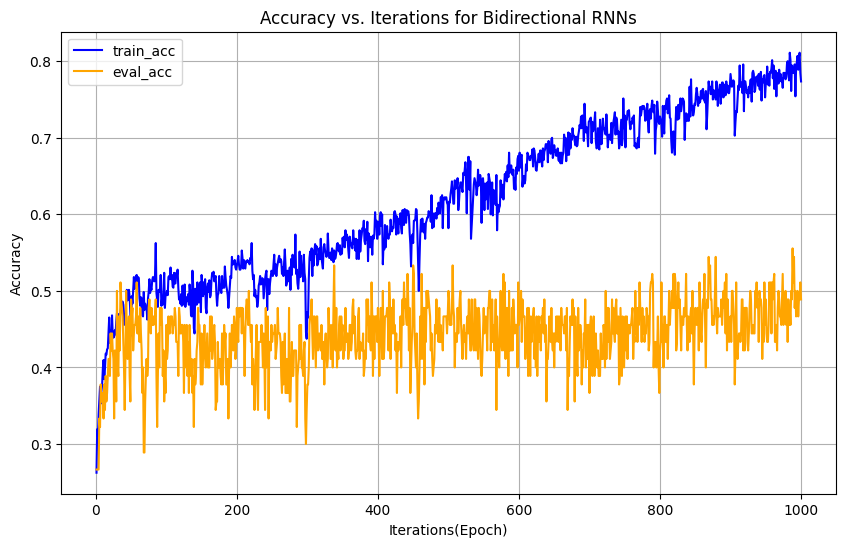

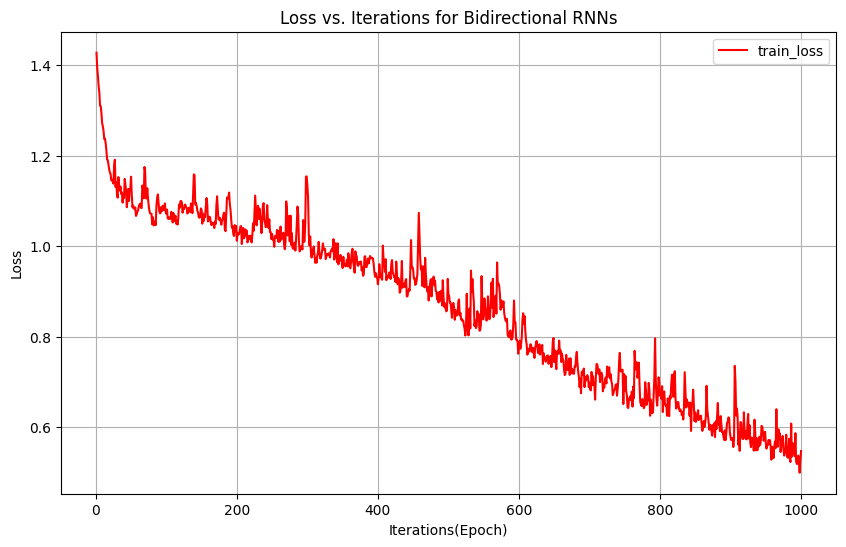

In [86]:
# plot train acc vs. iterations(epoch)
x_axis = list(range(1, num_epochs+1))
plt.figure(figsize=(10, 6))
# plot train acc
plt.plot(x_axis, bi_rnn_train_acc, color='blue')
# plot eval acc
plt.plot(x_axis, bi_rnn_eval_acc, color='orange')
#plt.xscale('log')
plt.xlabel('Iterations(Epoch)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iterations for Bidirectional RNNs')
plt.grid(True)
plt.legend(['train_acc', 'eval_acc'])
plt.show()

# plot train loss vs. iterations(epoch)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, bi_rnn_train_loss, color='red')
#plt.xscale('log')
plt.xlabel('Iterations(Epoch)')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations for Bidirectional RNNs')
plt.grid(True)
plt.legend(['train_loss'])
plt.show()

In [87]:
# Evaluate the rnn model
bi_rnn_model.eval()  
correct = 0
total = 0

with torch.inference_mode():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = bi_rnn_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy on the test set: 48.888888888888886%


Done with bidirectional RNNs.

### LSTM Model 
(Long Short Term Memory)

<img src="LSTM_2.png" alt="LSTM" style="width:400px; height: auto;">

1. Forget. **$z^f$** controls the part where we want to forget about the last stage **$c^{t-1}$**. It forgets the unimportant elements. By Hadamard Product.

2. Select information to remember. **$z^i$** controls the information we want to keep. With the **z** which is the input from the last stage, combined with the results after "forget", we pass the results to the next stage **$c^t$**.

3. Output. **$z^o$** controls the output **$y^t$**.

In [33]:
### Xinyu(Xiyah) Chang ###

# Define LSTM Model
# Need a input with shape (720, 1295, 204)
class MusicEmotionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MusicEmotionLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # batch_first=True gives the input and output tensors in the format:
        # (batch, seq, feature) instead of (seq, batch, feature)
        # batch: 720
        # seq: which is timestep, here should be 1295
        # feature: 204
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully Connected Layer output the prediction
        # batchnorm is usually used before activation func
        # dropout is usually used after activation func
        # use batchnorm before dropout: 
        #   first stabalize data then pass to dropout layer
        self.fc = nn.Sequential(
            nn.Linear(num_layers * hidden_size, hidden_size), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2), 

            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2), 

            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        # Initialize hidden and cell states
        # x.size(0) is batch size
        # Bidirectional Rnn returns 
        # h0: tensor of shape (Number of Layers, Batchsize, hidden_size)
        h0 = torch.rand(self.num_layers * num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.rand(self.num_layers * num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward
        output, (final_ht, final_ct) = self.lstm(x, (h0, c0))
        #print(f"final_ht: {final_ht.shape}")

        return self.fc(final_ht[0])
### Xinyu(Xiyah) Chang ###

In [34]:
# Model Params
input_size = 204     # seq in (batch, seq, feature)
hidden_size = 128    # Can adjust based on model complexity and dataset, used: 128
num_layers = 1       # Number of RNN layers, 1 or 2, 1 is better by training
num_classes = 4      # Four quadrants
learning_rate = 3e-4 # Can adjust this learing rate， 1e-4, 3e-4, 1e-3, 3e-3
num_epochs = 250      # Number of epochs
batch_size = 128     # size of batch

lstm_rnn_model = MusicEmotionLSTM(input_size, hidden_size, num_layers, num_classes)

# Use DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(dataset=eval_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Assuming use of CrossEntropyLoss and an optimizer Adam
criterion = nn.CrossEntropyLoss()

In [35]:
### Xinyu(Xiyah) Chang ###

# Define the device 
# "cuda", "mps", "cpu"
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda')

# Move model to the chosen device
lstm_rnn_model = lstm_rnn_model.to(device)
lstm_rnn_optimizer = optim.AdamW(lstm_rnn_model.parameters(), lr=learning_rate)

total_batches = math.ceil( X_train_norm.shape[0] / batch_size)
#total_batches = 7
lstm_rnn_model.train()  

# record train acc and loss
lstm_rnn_train_acc = []
lstm_rnn_train_loss = []

# record eval acc
lstm_rnn_eval_acc = []

for epoch in trange(num_epochs):
    running_loss = 0.0
    prog = enumerate(train_loader) #tqdm(enumerate(train_loader), total=total_batches, desc=f'Epoch {epoch+1}/{num_epochs}')

    # initialize accuracy count for each new epoch
    correct = 0
    total = 0

    for i, (inputs, labels) in prog:
        # Move data to the chosen device
        # print(inputs)
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.shape)

        # Forward pass
        outputs = lstm_rnn_model(inputs)
        # print(outputs.shape)
        # print(outputs, labels)
        # break
        loss = criterion(outputs, labels)

        # Zero the parameter gradients
        lstm_rnn_optimizer.zero_grad(set_to_none=False)

        # Backward pass and optimize
        loss.backward()

        # clip gradient to prevent explosion
        # torch.nn.utils.clip_grad_norm_(lstm_rnn_model.parameters(), 20.0)
        lstm_rnn_optimizer.step()

        running_loss += loss.item()
        __, predicted = torch.max(outputs.data, dim=1)
        # print(f"predicted: {predicted}")
        # print(f"labels: {labels}")
        # print((predicted==labels).sum())   # tensor(41, device='mps:0')
        correct += (predicted==labels).sum().item()                         # Easily getting Error!
                                                    # before modifying, this part I forgot to add up "total" for all batches loops
        total += labels.size(0)
        #print(ct_acc)

    # calculate average loss and acc over training batches
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    lstm_rnn_train_acc.append(epoch_acc)
    lstm_rnn_train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc_train: {epoch_acc:.4f}')

    # evaluate using eval for each epoch
    lstm_rnn_model.eval() 

    with torch.inference_mode():
        eval_correct=0
        eval_total=0
        for i, (inputs, labels) in enumerate(eval_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lstm_rnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

        eval_accuracy = eval_correct / eval_total
        lstm_rnn_eval_acc.append(eval_accuracy)
        print(f'Validation Accuracy: {eval_accuracy:.4f}%')
    
    # set the model back to train mode
    lstm_rnn_model.train()

### Xinyu(Xiyah) Chang ###

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/250, Loss: 1.4426, Acc_train: 0.2597
Validation Accuracy: 0.3111%
Epoch 2/250, Loss: 1.3635, Acc_train: 0.3028
Validation Accuracy: 0.2556%
Epoch 3/250, Loss: 1.3269, Acc_train: 0.3500
Validation Accuracy: 0.2556%
Epoch 4/250, Loss: 1.3179, Acc_train: 0.3069
Validation Accuracy: 0.3333%
Epoch 5/250, Loss: 1.3198, Acc_train: 0.3403
Validation Accuracy: 0.4333%
Epoch 6/250, Loss: 1.3105, Acc_train: 0.3319
Validation Accuracy: 0.4333%
Epoch 7/250, Loss: 1.2826, Acc_train: 0.3472
Validation Accuracy: 0.4556%
Epoch 8/250, Loss: 1.2779, Acc_train: 0.3708
Validation Accuracy: 0.3556%
Epoch 9/250, Loss: 1.2764, Acc_train: 0.3819
Validation Accuracy: 0.3667%
Epoch 10/250, Loss: 1.2905, Acc_train: 0.3542
Validation Accuracy: 0.3222%
Epoch 11/250, Loss: 1.2710, Acc_train: 0.3931
Validation Accuracy: 0.4000%
Epoch 12/250, Loss: 1.2579, Acc_train: 0.3792
Validation Accuracy: 0.4111%
Epoch 13/250, Loss: 1.2744, Acc_train: 0.3556
Validation Accuracy: 0.3333%
Epoch 14/250, Loss: 1.2435, Acc_tr

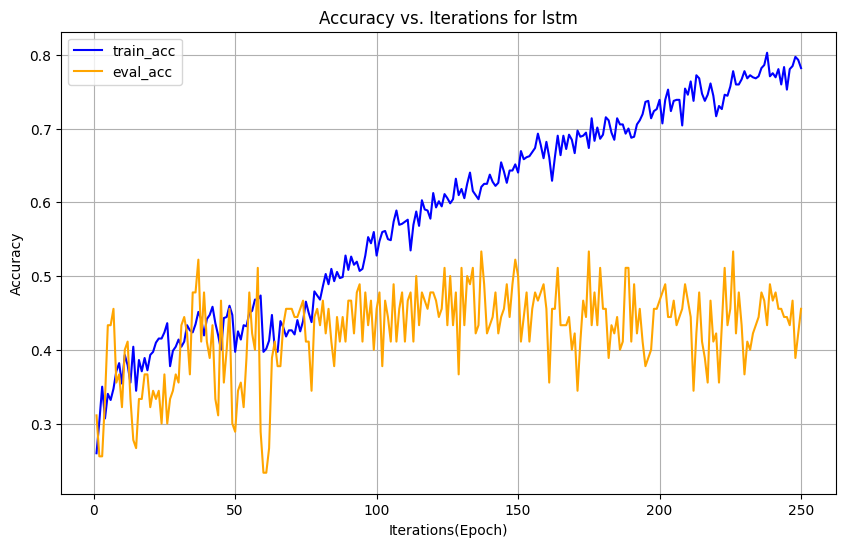

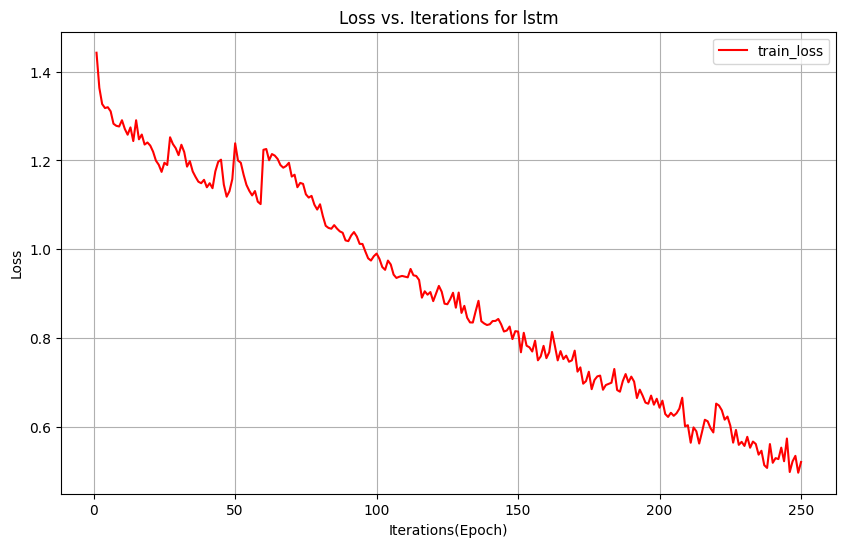

In [36]:
# plot train acc vs. iterations(epoch)
x_axis = list(range(1, num_epochs+1))
plt.figure(figsize=(10, 6))
# plot train acc
plt.plot(x_axis, lstm_rnn_train_acc, color='blue')
# plot eval acc
plt.plot(x_axis, lstm_rnn_eval_acc, color='orange')
#plt.xscale('log')
plt.xlabel('Iterations(Epoch)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iterations for lstm')
plt.grid(True)
plt.legend(['train_acc', 'eval_acc'])
plt.show()

# plot train loss vs. iterations(epoch)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, lstm_rnn_train_loss, color='red')
#plt.xscale('log')
plt.xlabel('Iterations(Epoch)')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations for lstm')
plt.grid(True)
plt.legend(['train_loss'])
plt.show()

In [37]:
# Evaluate the lstm model
lstm_rnn_model.eval()  
correct = 0
total = 0

with torch.inference_mode():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = lstm_rnn_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy on the test set: 51.111111111111114%
